# Astro 505 assignment 2
Brittany Howard

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import *
from astropy.cosmology import WMAP7 as cosmo # flat, wmap7 parameters

%matplotlib inline

# Question 1
* Compute and plot the luminosity distance and differential co-moving volume as a function of redshift over the interval $0 < z < 2$. You may assume that the Universe is described by a spatially flat Friedmann-Robertson-Walker model defined by the WMAP 7 cosmological parameters.


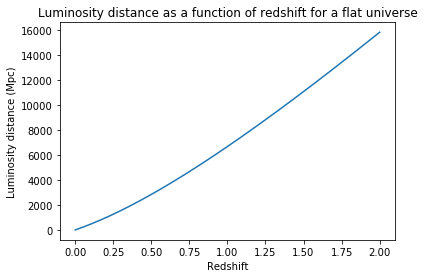

In [17]:
# define redshift range
z = np.arange(.001, 2.001, .001)

# get the luminosity distance
lum_dist = (cosmo.luminosity_distance(z)).value

# plot
plt.plot(z, lum_dist)
plt.title('Luminosity distance as a function of redshift for a flat universe')
plt.xlabel('Redshift')
plt.ylabel('Luminosity distance (Mpc)')

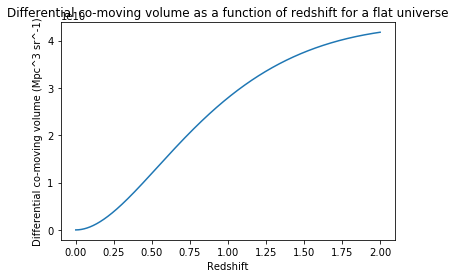

In [18]:
# Now I'll do the same for differential co-moving volume
diff_co_vol = (cosmo.differential_comoving_volume(z)).value

plt.plot(z, diff_co_vol)
plt.title('Differential co-moving volume as a function of redshift for a flat universe')
plt.xlabel('Redshift')
plt.ylabel('Differential co-moving volume (Mpc^3 sr^-1)')

* The CFHT Legacy Survey Deep component is a 4 deg$^2$ imaging survey complete to $r = 27.6$. Using the basic LF parameters from your notes (assume that they describe the r-band), at what redshift does a M∗ galaxy display an apparent magnitude equal to the survey magnitude limit? You may assume that the k-correction is dominated by the bandwidth term and that the rest-frame galaxy SEDs evolve to become brighter with increasing redshift according to $E(z) = M(z) − M(z = 0) = −0.75 × z$ for $z < 1$ and constant thereafter (i.e. $E(z) = −0.75$).

Note: this needs to be done by considering redshift "shells"; at higher redshift, we see fewer sufficiently bright glaxies, but the volume is larger, so there are more galaxies in total. So there should be a peack in number of galaxies that we can see at a given redshift somewhere.

So, we need to get apparent magnitude $m_r$ of an M * galaxy as a function of redshift, and then find the redshift at which the apparent magnitude $m_r = 27.6$.

We have a expression for doing this given in the notes section 1.5:

$M_r = m_r - 25 - 5\log d_L(z) -K_r(z) + A_r$.

Rearranging to isolate $m_r$ gives

$m_r = -M_r + 25 + 5\log d_L(z) + K_r(z) - A_r$.

$M_r$ is the absolute magnitude; $M^*$ is a characteristic magnitude, perhaps this is it? Better read about this. In the notes, it's given as -20.6.

We know the we can neglect the second term of the k-correction, so we have $K_r(z) = 2.5\log(1+z)$.

We can get luminiosity distance as a function of redshift with astropy, so now the only missing piece is the galactic extinction term. I'm pretty sure that this is what's given in the problem as $E(z)$.

Putting it all together, we have a piecewise function. For $z<1$, we get

$m_r = -M^* + 25 + 5\log d_L(z) + 2.5\log(1+z) + 0.75z$, 

and for $z \geq 1$, 

$m_r = -M^* + 25 + 5\log d_L(z) + 2.5\log(1+z) + 0.75$

This is the solution, but I'll make a plot so that I can visualize it:


In [19]:
def app_magn(z, M_star):
    if z < 1: 
        app_magn = -M_star + 25 + 5*np.log10((cosmo.luminosity_distance(z)).value) + 0.75 * z
    else:
        app_magn = -M_star + 25 + 5*np.log10((cosmo.luminosity_distance(z)).value) + 0.75
    return app_magn

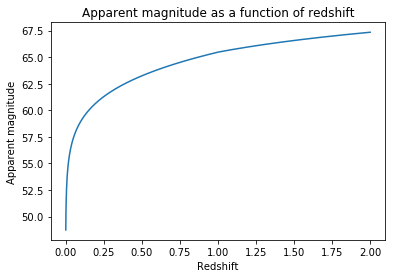

In [20]:
# calculate 
app_magnitude = np.array([])

for redshift in z:
    app_magnitude = np.append(app_magnitude, app_magn(redshift, -20.6))

# plot
plt.plot(z, app_magnitude)
plt.title('Apparent magnitude as a function of redshift')
plt.xlabel('Redshift')
plt.ylabel('Apparent magnitude')

IT SHOULD DECREASE AS RESSHIFT INCREASES; WHAT AM I DOING WRONG?

* What volume is contained within this redshift? 

This is the co-moving volume, I think. Or is it?

In [ ]:
vol_contained = cosmo.comoving_volume(z=)

* Using the local LF parameters and the above assumptions regarding the k-correction and evolutionary terms, how many galaxies would you expect to be observed in an r < 27.6 selected catalogue based upon CFHTLS Deep observations?

## Question 2
Compute the galaxy luminosity function for the Las Campanas Redshift Survey (LCRS). The LCRS consists of a sample of 18,678 galaxies with measured r–band apparent magnitudes and spectroscopic redshifts. Catalogue information for the LCRS may be obtained at the following URL:
     https://heasarc.gsfc.nasa.gov/w3browse/all/lcrscat.html
The LCRS LF analysis is described in Lin et al. 1996, ApJ, 464, 60.

* Retrieve the field and catalogue data and the paper. Note that, although the catalogue contains some 80,000 entries, we are only interested in those with redshift information.

In [103]:
# read in LCRS data
catalog = fits.getdata  ('\?')
catalog.column?s

ColDefs(
    name = 'FIELD_NAME'; format = 'A10'; start = 1
    name = 'NAME'; format = 'A21'; start = 12
    name = 'ISOPHOTAL_MAG'; format = 'F13.0'; unit = 'MAG'; disp = 'F13.2'; start = 34
    name = 'RADIAL_VELOCITY'; format = 'I15'; unit = 'KM/S'; start = 48
    name = 'RADIAL_VELOCITY_ERROR'; format = 'I21'; unit = 'KM/S'; start = 64
    name = 'CLASS'; format = 'A6'; start = 86
)

In [104]:
# have to solve for redshift, z = v/c
redshift = catalog['RADIAL_VELOCITY'] / (2.998 * 10 ** 5 ) # radial velocity in km/s

catalog = Table(catalog)
new_col = Column(redshift, name='REDSHIFT')
catalog.add_column(new_col)

In [105]:
catalog

FIELD_NAME,NAME,ISOPHOTAL_MAG,RADIAL_VELOCITY,RADIAL_VELOCITY_ERROR,CLASS,REDSHIFT
str10,str21,float64,int32,int32,str7,float64
0015-42M,LCRS B002517.7-421621,17.48,45629,56,GALAXY,0.152198132088
2255-42M,LCRS B231051.9-421601,16.12,1679,33,GALAXY,0.00560040026684
0400-42W,LCRS B040221.3-420748,17.36,63898,73,GALAXY,0.213135423616
2215-42W,LCRS B222214.5-421454,17.0,16210,56,GALAXY,0.0540693795864
2135-42W,LCRS B214037.7-421325,16.21,21454,40,GALAXY,0.0715610406938
0054-42M,LCRS B010511.2-421539,17.74,53196,56,GALAXY,0.177438292195
0134-42W,LCRS B014055.9-421443,16.6,28587,47,GALAXY,0.095353569046
0015-42W,LCRS B002338.6-421614,17.24,45735,57,GALAXY,0.152551701134
0415-42W,LCRS B041730.1-420647,17.12,15876,38,GALAXY,0.0529553035357


* Use the FRW WMAP 7 cosmological model described earlier.

Okay, no need to do anything here.

* Compute the galaxy luminosity function:

* Equations (1), (2), and (3) of the Lin et al. paper make several assumptions regarding the treatment of cosmological effects. Question each assumption as follows:

* i. Equation (1) assumes that the effects of passive stellar evolution within the sample are small. What is the computed look–back time between a redshift z = 0 and the median redshift of the sample (z = 0.1)? Would you expect passive stellar evolution to be much of an effect here? Justify your answer with reference to the typical main sequence turn off ages of different stellar types or with reference to any relevant literature on the expected amplitude of stellar evolution. Assume that a typical star in a typical LCRS galaxy is 6 Gyr old.

Okay, so first let's calculate the lookback time:

In [106]:
lookback = cosmo.lookback_time(z=0.1)
print('Lookback time: {}'.format(lookback))

Lookback time: 1.296565616647543 Gyr


And what are some typical main sequence turnoff ages? Here are some examples from the university of Iowa(http://astro.physics.uiowa.edu/ITU/labs/observational-labs/photometry-of-a-globular/part-3-finding-the-ms-turn.html):

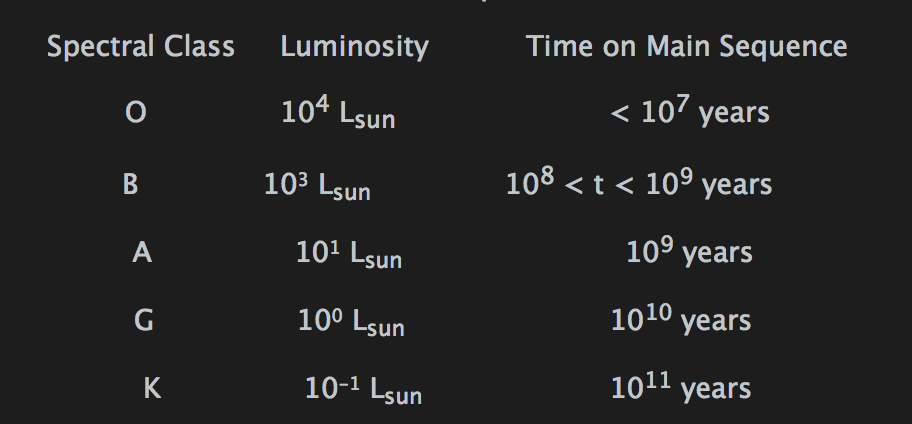

If the median lookback time is $1.3\times 10 ^8$ years, it's possible that passive stellar evolution plays a significant role for O and B type stars, but not for other spectral types since their turnoff ages are at least an order of magnitude higher than the lookback time.

* ii. Equation (2) provides an expression for the luminosity distance in terms of the deceleration parameter $q_0$. The parameter $q_0 = Ω_M/2$ and assumes that $Ω_Λ = 0$. How does the luminosity distance expression given in Lin et al. compare to the value returned by your cosmological model? Express your answer in terms of the distance modulus.

Okay, so what value do we get using Lin's expression? For WMAP7, $\Omega_M=0.272$, so $q_0 = 0.136$.

Lin's expression is:

$d_L = \frac{c}{H_0q_0^2}\bigg[q_0z+(1-q_0)(1-\sqrt{1+2q_0z}\bigg]$.

I'll evaluate it now:

In [107]:
def lin_dl(c, H0, q0, z):
    dl = (c / (H0 * q0**2)) * (q0 * z + (1 - q0)*(1 - np.sqrt(1 + 2 * q0 *z)) )
    return(dl)

In [108]:
lum_dist_lin = lin_dl(2.998*10**5, cosmo.H0.value, 0.136, .1)  # assuming median redshift value
lum_dist_wmap7 = cosmo.luminosity_distance(z=0.1).value
print('Luminosity distance as given by Lin: {} Mpc'.format(lum_dist_lin))
print('Luminosity distance as given by WMAP7 cosmology: {} Mpc'.format(lum_dist_wmap7))

Luminosity distance as given by Lin: 444.00306816001176 Mpc
Luminosity distance as given by WMAP7 cosmology: 458.64149272470024 Mpc


Now let's get the distance modulus: $M - m = -25 -5 \log{(d_L)} - k(z)$

What should we use for the k-correction? According to Lin, we can take it to be $k(z) = 2.5\log{(1+z)}$ for LCRS.

In [109]:
def get_dist_mod(dl, z):
    dist_mod = -25 - 5 * np.log10(dl) - 2.5 * np.log10(1 + z)
    return dist_mod

In [110]:
dist_mod_Lin = get_dist_mod(lum_dist_lin, 0.1)
dist_mod_wmap7 = get_dist_mod(lum_dist_wmap7, 0.1)

print('Distance modulus as given by Lin: {} Mpc'.format(dist_mod_Lin))
print('Distance modulus as given by WMAP7 cosmology: {} Mpc'.format(dist_mod_wmap7))

Distance modulus as given by Lin: -38.34041156887811 Mpc
Distance modulus as given by WMAP7 cosmology: -38.41084842415677 Mpc


Pretty close!

* iii. Equation (3) assumes that the k–correction is dominated by the bandwidth term and not by any spectral variation. Test this assumption by computing the full k– correction term at a redshift z = 0.1 for two template spectra representing a typical early–type (ell) and late–type (scd) galaxies. Are the results significantly different than the result obtained using the bandwidth term alone?

* Compute the absolute r–band magnitude for each galaxy in the sample. For simplicity, you may assume that Equations (1–3) of Lin et al. are good approximations. Note that the apparent magnitude limits for each galaxy vary as a function of survey field (there are 289 survey fields). It will speed things up later on if you compute the absolute magnitude limits (from the apparent magnitude limits for the field) for each galaxy at this stage as well. Note that you should be working with isophotal, not central, magnitudes. Plot the variation of absolute isophotal magnitude versus redshift for a representative 112 and 50 fibre field. Plot the effective absolute magnitude limits as a function of redshift of the field on each plot as well.

To calculate the absolute magnitude, we can use the distance modulus equation. I'll do that first:

In [111]:
new_col = Column(dist_mod_Lin + catalog["ISOPHOTAL_MAG"], name='ABSOLUTE_MAG')
catalog.add_column(new_col)

In [112]:
catalog

FIELD_NAME,NAME,ISOPHOTAL_MAG,RADIAL_VELOCITY,RADIAL_VELOCITY_ERROR,CLASS,REDSHIFT,ABSOLUTE_MAG
str10,str21,float64,int32,int32,str7,float64,float64
0015-42M,LCRS B002517.7-421621,17.48,45629,56,GALAXY,0.152198132088,-20.8604115689
2255-42M,LCRS B231051.9-421601,16.12,1679,33,GALAXY,0.00560040026684,-22.2204115689
0400-42W,LCRS B040221.3-420748,17.36,63898,73,GALAXY,0.213135423616,-20.9804115689
2215-42W,LCRS B222214.5-421454,17.0,16210,56,GALAXY,0.0540693795864,-21.3404115689
2135-42W,LCRS B214037.7-421325,16.21,21454,40,GALAXY,0.0715610406938,-22.1304115689
0054-42M,LCRS B010511.2-421539,17.74,53196,56,GALAXY,0.177438292195,-20.6004115689
0134-42W,LCRS B014055.9-421443,16.6,28587,47,GALAXY,0.095353569046,-21.7404115689
0015-42W,LCRS B002338.6-421614,17.24,45735,57,GALAXY,0.152551701134,-21.1004115689
0415-42W,LCRS B041730.1-420647,17.12,15876,38,GALAXY,0.0529553035357,-21.2204115689


In [113]:
# now I will find the absolute magnitude limits

# add columns for the field max and min
# fill with 9999s for now
catalog['FIELD_MAX']=9999
catalog['FIELD_MIN']=9999

In [121]:
# first step is to get all of the field-names
field_names = unique(catalog, keys='FIELD_NAME')
field_names = field_names['FIELD_NAME'].data

# now loop through field-names
for field in field_names:
    
    # find all of the row with this field name
    gals_in_field = catalog[np.where(catalog['FIELD_NAME']==field)]
    
    # find the min and max of their absolute magnitudes
    abs_mags = gals_in_field['ABSOLUTE_MAG'].data
    
    field_max = np.amax(abs_mags)
    field_min = np.amin(abs_mags)

    # add these values to the correct columns of all galaxies in field
    catalog['FIELD_MAX'][np.where(catalog['FIELD_NAME'] == field)] = field_max
    catalog['FIELD_MIN'][np.where(catalog['FIELD_NAME'] == field)] = field_min

catalog.sort('FIELD_NAME')  # sort by field to make things easier

In [122]:
# take a look
catalog

FIELD_NAME,NAME,ISOPHOTAL_MAG,RADIAL_VELOCITY,RADIAL_VELOCITY_ERROR,CLASS,REDSHIFT,ABSOLUTE_MAG,FIELD_MAX,FIELD_MIN
str10,str21,float64,int32,int32,str7,float64,float64,int64,int64
0000-42E,LCRS B001409.1-411736,17.41,48180,78,GALAXY,0.160707138092,-20.9304115689,-20,-22
0000-42E,LCRS B000901.2-423317,17.03,25790,52,GALAXY,0.0860240160107,-21.3104115689,-20,-22
0000-42E,LCRS B001329.9-414742,16.4,25400,52,GALAXY,0.0847231487658,-21.9404115689,-20,-22
0000-42E,LCRS B001041.8-422515,16.44,25300,39,GALAXY,0.084389593062,-21.9004115689,-20,-22
0000-42E,LCRS B000937.7-420403,16.61,35650,52,GALAXY,0.118912608406,-21.7304115689,-20,-22
0000-42E,LCRS B001347.1-415830,17.11,37580,65,GALAXY,0.125350233489,-21.2304115689,-20,-22
0000-42E,LCRS B001142.3-422514,16.85,25910,39,GALAXY,0.0864242828552,-21.4904115689,-20,-22
0000-42E,LCRS B000920.5-414324,17.12,27170,39,GALAXY,0.0906270847231,-21.2204115689,-20,-22
0000-42E,LCRS B001313.8-414656,17.31,46060,65,GALAXY,0.153635757171,-21.0304115689,-20,-22


For some reason, the mins and maxes are all turning out to be integers instead of floats... I'll need to fix this later. For now, I will make some plots:

In [214]:
# first, find two fields, one with ~50 galaxies in it, one with ~112
small = False
big = False

for field in field_names:
    if small==True and big==True:
        break
        
    # find all of the row with this field name
    gals_in_field = catalog[np.where(catalog['FIELD_NAME']==field)]
    num_gals = len(gals_in_field['FIELD_NAME'].data)
    
    if 48 < num_gals < 52:
        print('Field {} has {} galaxies in it'.format(field, num_gals))
        field1 = gals_in_field
        small = True
        app_mags = gals_in_field['ISOPHOTAL_MAG'].data
        print(app_mags)
        # find the max and min
        #m_max1 = np.amax(app_mags)
        #m_min1 = np.amin(app_mags)
      

    if 109 < num_gals < 112:
        print('\nField {} has {} galaxies in it'.format(field, num_gals))
        field2 = gals_in_field
        big = True
        app_mags = gals_in_field['ISOPHOTAL_MAG'].data
        # find the max and min
        #m_max2 = np.amax(app_mags)
        #m_min2 = np.amin(app_mags)
      

/Users/brittanyhoward/anaconda/lib/python3.6/site-packages/astropy/table/column.py:928: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return getattr(self.data, oper)(other)
/Users/brittanyhoward/anaconda/lib/python3.6/site-packages/astropy/table/table.py:2628: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


In [212]:
field1_name = field1['FIELD_NAME'][0]
field2_name = field2['FIELD_NAME'][0]

print(m_max1, m_max2, m_min1, m_min2)

NameError: name 'm_max1' is not defined

In [187]:
# okay, I realize now that this is not what I was supposed to do. Instead, I need to look at each galaxy individually,
# decide if it's part of a 50 fiber or 112 fiber field, and then I can calculate its absolute magnitude limit for its 
# redshift based on what type of field it is in, then add this limit as a column to the catalog table

def get_abs_mag_limit(galaxy, m_min, m_max):
    # from the Lin paper
    z = galaxy['REDSHIFT'].data
    M_min = m_min - 25 - 5 * np.log(cosmo.luminosity_distance(z=z) - 2.5* np.log(1 + z)
    M_max = m_max - 25 - 5 * np.log(cosmo.luminosity_distance(z=z) - 2.5* np.log(1 + z)
                                    
     # find all of the row with this field name
    gals_in_field = catalog[np.where(catalog['FIELD_NAME']==field)]
    
    # find the min and max of their absolute magnitudes
    abs_mags = gals_in_field['ABSOLUTE_MAG'].data
    
    field_max = np.amax(abs_mags)
    field_min = np.amin(abs_mags)

    # add these values to the correct columns of all galaxies in field
    catalog['FIELD_MAX'][np.where(catalog['FIELD_NAME'] == field)] = field_max
    catalog['FIELD_MIN'][np.where(catalog['FIELD_NAME'] == field)] = field_min
    
    
# loop through each galaxy in order
galaxies = catalog['NAME']
field_names = [field1, field2]
mins = []
for galaxies in galaxy_names:
    abs_mag_limit = get_abs_mag_limit(galaxy)
    # append this value to a new column

# add the new column to the catalog
       

['LCRS B001409.1-411736' 'LCRS B000901.2-423317' 'LCRS B001329.9-414742'
 ..., 'LCRS B000124.0-445151' 'LCRS B235847.8-450207'
 'LCRS B000443.7-443734']


NameError: name 'get_abs_mag_limit' is not defined

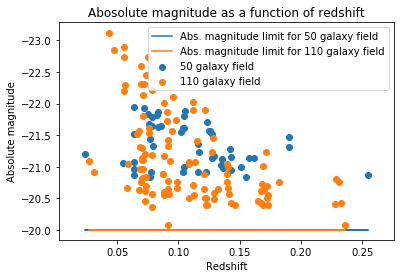

In [175]:
# absolue magnitude vs redshift for each of these fields
plt.scatter(field1['REDSHIFT'].data,field1['ABSOLUTE_MAG'].data, label='50 galaxy field')
plt.scatter(field2['REDSHIFT'].data, field2['ABSOLUTE_MAG'].data, label='110 galaxy field')
# add the magnitude limits
plt.plot(field1['REDSHIFT'].data, field1['FIELD_MAX'].data, label='Abs. magnitude limit for 50 galaxy field')
plt.plot(field2['REDSHIFT'].data, field2['FIELD_MAX'].data, label='Abs. magnitude limit for 110 galaxy field')

plt.legend()
plt.gca().invert_yaxis()
plt.title('Abosolute magnitude as a function of redshift')
plt.xlabel('Redshift')
plt.ylabel('Absolute magnitude')

* Compute LF parameters for the LCRS sample employing the either the $1/V_{acc}$ or STY estimators. You may assume that the form of the LF is given by the Schechter function as detailed in Lin et al. Equation (8). Quote your answer in terms of a best–fitting characteristic magnitude, M∗, and faint–end slope, α. Also provide contours of relative likelihood in the M∗ versus α plane corresponding to a 2σ variation in the parameters.